In [226]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages

In [227]:
base_path = "/Volumes/DATA/"
sphere_data = ["20231009/1",
               "20231009/3",]

calib_data = ["20230925/calibration",]
calib_noise_path = ["20230925/calibration/noise/1",]

file_label= '20231009'
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
plots_dir = os.path.join(code_path, "plots", file_label)
if(not os.path.isdir(plots_dir)):
    os.makedirs(plots_dir)
data_dir = os.path.join(code_path, "data", file_label)
if(not os.path.isdir(data_dir)):
    os.makedirs(data_dir)


In [228]:
## make a list of all the calibration files and sort by impulse size
data_list = []
for curr_path in sphere_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5")))
    for file in curr_file_list:
        data_list.append(file)

In [229]:
## process data to find charge correlation
importlib.reload(bu)

remake_files = False

num_pts_per_charge_recon = 2**16 ## points to use in each fft segment for charge reconstruction

if(remake_files):
    charge_vec = []
    corr_vec = []
    for i,f in enumerate(data_list):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        fname = "corr_%d.png"%i
        #corr_val, curr_corr_vec = bu.simple_correlation_with_drive(cdat, attr, drive_freq, bw=1, decstages=50)
        curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=num_pts_per_charge_recon)
        if(i == 0):
            corr_vec = 1.0*curr_corr_vec
        else:
            corr_vec = np.vstack((corr_vec, curr_corr_vec))

        corr_val = np.median(curr_corr_vec[:,0])

        time = attr["Time"]
        charge_vec.append([time, corr_val])

    charge_vec = np.array(charge_vec)
    np.save(data_dir+"/charge_steps_%s.npy"%file_label, charge_vec)
    np.save(data_dir+"/charge_steps_vec_%s.npy"%file_label, corr_vec)
else:
    charge_vec = np.load(data_dir+"/charge_steps_%s.npy"%file_label)
    corr_vec = np.load(data_dir+"/charge_steps_vec_%s.npy"%file_label)

In [230]:
## Make a list of folder numbers and file names
cdat, attr, fhandle = bu.get_data(data_list[0])
num_pts_per_file = int(len(cdat[:,0])/num_pts_per_charge_recon)
folder_vec = []

for j,f in enumerate(data_list):
    parts = f.split('/')
    folder_vec.append([int(parts[4])]*num_pts_per_file)
folder_vec = np.ndarray.flatten(np.array(folder_vec))

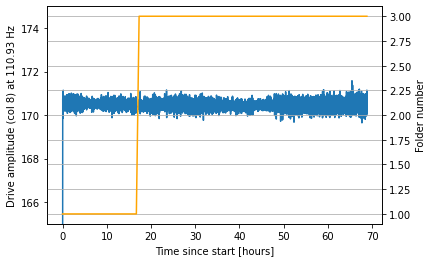

In [231]:
## plot the time correlation with the drive
time_hours = (corr_vec[:,-1]-corr_vec[0,-1])/3600

plt.figure(figsize =(6,4))
plt.plot(time_hours, corr_vec[:,3])
plt.xlabel("Time since start [hours]")
plt.ylabel("Drive amplitude (col 8) at 110.93 Hz")
plt.ylim(165, 175)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time_hours, folder_vec, color='orange')
plt.ylabel("Folder number")
plt.grid(True)


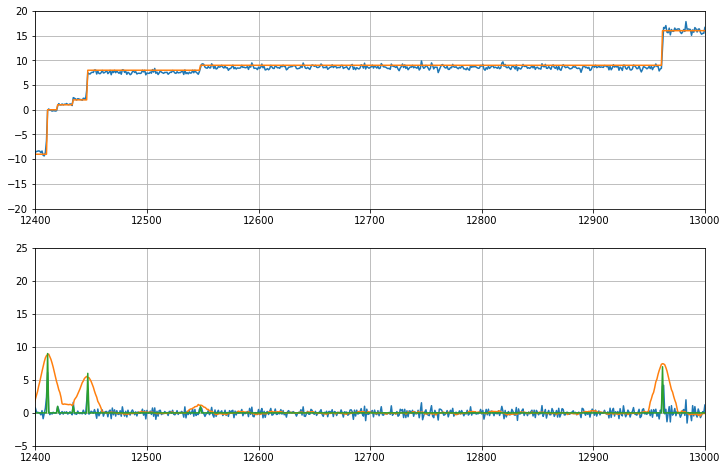

In [232]:
## initial plot of the charge steps versus time
cal_fac = 0.072 ## back to normal factor
corr_idx = 2
recal = np.ones_like(corr_vec[1:,corr_idx])

xmin, xmax = 12400, 13000 #len(corr_vec)
ymin, ymax = -20, 20
init_charge = 10

corr_vec[:32] = init_charge*cal_fac ## no drive in the first file, second file also
                                    ## hard to decipher so just skip it

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)

plt.subplot(2,1,2)
dv = np.diff(corr_vec[:,corr_idx]/cal_fac)
plt.plot(dv)
b,a = sig.butter(3,0.3)
dv2 = sig.filtfilt(b,a,dv)
dv_chopped = np.round(dv)
N=25
dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')
bpts = ((np.abs(dv2) < 5) | (np.abs(dv) < 5)) # | (np.abs(dv) < 0.07*corr_vec[:-1, corr_idx]/cal_fac)
dv_chopped[bpts] = 0
#dv_chopped[dv_chopped > 5] = dv2[dv_chopped > 5]

plt.plot(dv2)
## fix up missed steps
step_vals = np.loadtxt(data_dir+"/step_locations_%s.txt"%file_label, skiprows=1, delimiter=',')
for i in range(np.shape(step_vals)[0]):
    cvals = step_vals[i,:]
    if(cvals[1] > 0):
        dv_chopped[int(cvals[0]):int(cvals[1])] = cvals[2]
    else:
        dv_chopped[int(cvals[0])] = cvals[2]

plt.plot(dv_chopped)
plt.xlim(xmin, xmax)
plt.ylim(-5,25)
plt.grid(True)

running_charge = np.cumsum(dv_chopped) + init_charge
plt.subplot(2,1,1)
plt.plot(running_charge, '-')
plt.show()

In [233]:
importlib.reload(bu)

## make a dead time vector
live_vec = 1.0*time_hours
bad_pts = (time_hours > 67) # (folder_vec == 5) | (time_hours > 55)
live_vec = live_vec[~bad_pts]

calib_lamp_list = [[17.68, 18.05], [20.97, 21.0], [23.4, 23.8], [25.27, 25.4], [46.35, 46.45]]
calib_lamp = np.zeros_like(time_hours, dtype=bool)
for cl in calib_lamp_list:
    calib_lamp = calib_lamp | ((time_hours>cl[0]) & (time_hours<cl[1])) ## times when the lamp calibration is on
live_vec_lamp = time_hours[~calib_lamp]

buff_before = 10/3600 # 10s before
buff_after = 10/3600 # 10s after
filament_changes = time_hours[:-1][dv_chopped < 0]
calib_filament = time_hours < -1000 ## False vector
for fc in filament_changes:
    calib_filament = calib_filament | ((time_hours > fc-buff_before) & (time_hours < fc+buff_after))
live_vec_filament = time_hours[~calib_filament]

dead_period_edges = bu.get_edges_from_livetime_vec(live_vec, time_hours, [])
lamp_period_edges = bu.get_edges_from_livetime_vec(live_vec_lamp, time_hours, dead_period_edges)
filament_period_edges = bu.get_edges_from_livetime_vec(live_vec_filament, time_hours, dead_period_edges+lamp_period_edges)

print(filament_period_edges)

tot_dead_periods = 0
dead_periods_to_use = [dead_period_edges, lamp_period_edges, filament_period_edges]
for dpe in dead_periods_to_use:
    for dp in dpe:
        tot_dead_periods += dp[1]-dp[0]


tot_livetime = time_hours[-1] - tot_dead_periods
print(time_hours[-1], tot_dead_periods, tot_livetime)    


[[0.1731006255414751, 0.18075674096743266], [0.35013841695255704, 0.35782001866234675], [3.5681646960311464, 3.5758194245232477], [3.874548503425386, 3.8818302811516654], [5.041783068312539, 5.051260172923406], [5.073105506234699, 5.082581788169013], [5.277836060788896, 5.287285200887256], [5.486079099310769, 5.493707232077917], [5.51555256538921, 5.523211166063945], [5.545056499375237, 5.552733945184284], [5.692582574023141, 5.700285784271029], [5.781112140284645, 5.788783478339513], [5.810628811650806, 5.8182627638181055], [6.017130497429106, 6.024792152113385], [6.046637485424678, 6.0542667351828685], [6.076112068494161, 6.083746011389627], [6.135100825362735, 6.142754741112391], [6.164600074423684, 6.172280290656619], [6.1941256239679126, 6.201738242705663], [6.2235835760169556, 6.231202012962765], [6.253047346274058, 6.260684911807378], [6.282530245118671, 6.290197994311651], [6.931372601191203, 6.939025113450156], [7.934396883779102, 7.9420228007104665], [7.963868134021759, 7.971

In [234]:
## define plotting function for dead times
def fill_dps(dead_period_edges, color='blue', lab="Dead time"):
    yy = plt.ylim()
    for i,dp in enumerate(dead_period_edges):
        if(i==0 and len(lab)>0):
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color=color, alpha=0.2, label=lab)
        else:
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color=color, alpha=0.2)  
    plt.ylim(yy)

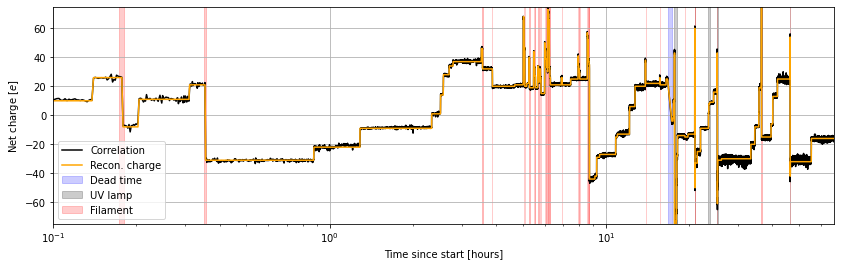

In [235]:
## now make some cleaned up versions of the charge step plots versus time
plt.figure(figsize=(14,4))
#plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
t12 = 10.6
xv1, xv2 = 0.1, 67
time_vals = time_hours[1:]
plt.plot(time_vals, corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_vals, running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="lower left")
plt.ylim(-75,75)
plt.gca().set_xscale('log')
plt.xlim(xv1, xv2)

#plt.subplot(2,1,2)
#plt.semilogy(time_vals, np.abs(corr_vec[1:,corr_idx]/cal_fac*recal), 'k-', label="Correlation")
#plt.plot(time_vals, np.abs(running_charge), '-', color='orange', label="Recon. charge")
#plt.grid(True)
#plt.ylim(0.5,250)
#fill_dps(dead_period_edges)
#plt.gca().set_xscale('log')
#plt.xlim(xv1, xv2)
#plt.ylabel("Abs(Net charge) [$e$]")
#plt.xlabel("Time since start [hours]")

plt.savefig(plots_dir+"/recon_charge_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [236]:
## find the locations of the charge changes
all_bad_periods = dead_period_edges + lamp_period_edges + filament_period_edges
bad_pts = np.zeros_like(time_hours[:-1], dtype=bool)
for dp in all_bad_periods:
    bad_pts = bad_pts | ((time_hours[:-1] > dp[0]) & (time_hours[:-1] < dp[1]))

changes = (np.abs(dv_chopped) > 0) & (dv_chopped > -1) & ~bad_pts
big_changes = (np.abs(dv_chopped) >= 8) & (dv_chopped > -1) & ~bad_pts


## group consecutive changes
idx_of_charge_changes = np.where(changes)[0]
dup_changes = np.diff(idx_of_charge_changes) <= 1
good_change_list = [ [time_hours[idx_of_charge_changes[0]], dv_chopped[idx_of_charge_changes[0]], running_charge[idx_of_charge_changes[0]-1]] ] 
for j in range(1,len(idx_of_charge_changes)):
    is_dup = dup_changes[j-1]
    if(is_dup):
        good_change_list[-1][1] += dv_chopped[idx_of_charge_changes[j]]
        continue
    good_change_list.append([time_hours[idx_of_charge_changes[j]], dv_chopped[idx_of_charge_changes[j]], running_charge[idx_of_charge_changes[j]-1]])

good_change_list = np.array(good_change_list)

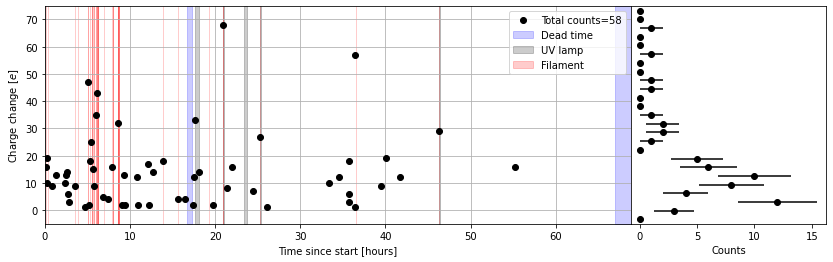

In [237]:
## plot charge changes vs time
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(14, 4), width_ratios=[3,1])

plt.sca(scatter_ax)
#scatter_ax.plot(time_hours[1:][changes], dv_chopped[changes], 'ro', label='Total counts=%d'%np.sum(changes))
scatter_ax.plot(good_change_list[:,0], good_change_list[:,1], 'ko', label='Total counts=%d'%len(good_change_list[:,1]))
ymin, ymax = -5, 1.1*np.max(good_change_list[:,1])
plt.ylim(ymin,ymax)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.grid(True)
plt.xlim(0, time_hours[-1])
plt.ylabel("Charge change [$e$]")
plt.xlabel("Time since start [hours]")
plt.legend()

hh, be = np.histogram(good_change_list[:,1], bins=25, range=(ymin,ymax))
bc = be[:-1] + np.diff(be)/2
#plt.step(be[:-1], hh, where='post', color='k')
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko')
plt.yticks([])
plt.ylim(ymin,ymax)
plt.xlabel("Counts")
plt.subplots_adjust(wspace=0)

plt.savefig(plots_dir+"/charge_changes_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

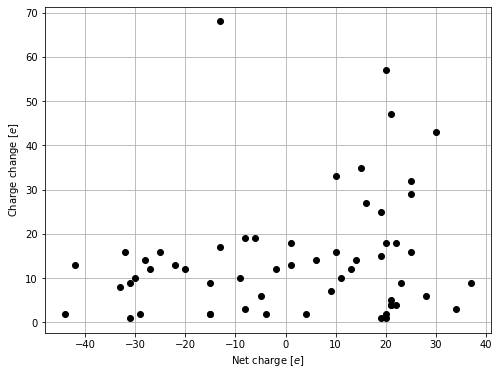

In [238]:
plt.figure(figsize=(8,6))
plt.plot(good_change_list[:,2], good_change_list[:,1], 'ko')
plt.xlabel("Net charge [$e$]")
plt.ylabel("Charge change [$e$]")
plt.grid(True)
plt.savefig(plots_dir+"/charge_changes_vs_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [239]:
def lfun(t, N0, t12, tot_time=tot_livetime, use_norm=True, dead_period_edges=all_bad_periods):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12), tint)
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=tot_livetime):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

69.77814338901246 70.30098326880945


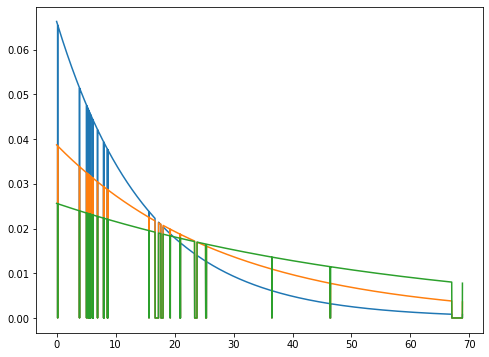

In [240]:
t = np.linspace(0, time_hours[-1], 5000)
plt.figure(figsize=(8,6))
plt.plot(t, lfun(t, 1, 10.6))
plt.plot(t, lfun(t, 1, 20))
plt.plot(t, lfun(t, 1, 40))
print(np.trapz(lfun(t, 1, 10.6)),np.trapz(lfun(t, 1, 20)))

In [241]:
## time of decays/half life
decay_times = good_change_list[:,0] #time_hours[1:][changes]
#big_decay_times = time_hours[1:][big_changes]

## likelihood fit
N0_vec = np.linspace(0, 150, 210)
t12_vec = np.linspace(0.5, 25, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))
#nll_mat_big = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)
        #nll_mat_big[i,j] = nll(big_decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)
#nll_mat_big -= np.min(nll_mat_big)

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_26068/412691564.py:18: RuntimeWarning: divide by zero encountered in log
  poiss = N*np.log(mu) - mu


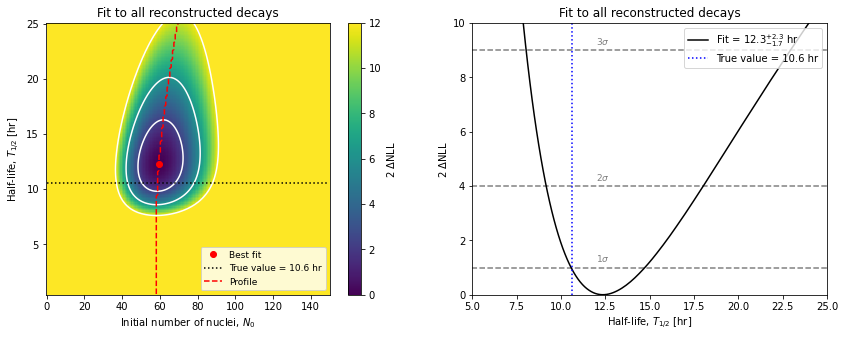

In [242]:
t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all,] # nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

fig2d = plt.figure(figsize=(14,5))
params_from_profile = []
for j in range(1):

    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    plt.figure(fig2d.number)
    plt.subplot(1,2,j+2)
    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    plt.plot(t12_vec, profile_nll, 'k', label="Fit = $%.1f^{+%.1f}_{-%.1f}$ hr"%(cv, uv-cv, cv-lv))
    plt.ylim(0, 10)
    levels = [1, 4, 9]
    for lidx, l in enumerate(levels):
        plt.plot(t12_vec, l*np.ones_like(t12_vec), 'k--', alpha=0.5)
        plt.text(12, l+0.2, "$%d\sigma$"%(lidx+1), fontsize=9, color='gray')
    plt.plot([t12_true, t12_true], [0, 10], 'b:', label="True value = %.1f hr"%t12_true)
    plt.xlim(5,25)
    plt.xlabel("Half-life, $T_{1/2}$ [hr]")
    plt.ylabel("2 $\Delta$NLL")
    plt.legend(loc="upper right")
    plt.title(labs[j])

    plt.figure(fig2d.number)
    plt.subplot(1,2,j+1)
    plt.pcolormesh(N0_vec, t12_vec, 2*nlls[j].T, cmap='viridis', vmin=0, vmax=12)
    plt.colorbar(label="2 $\Delta$NLL")
    min_loc = np.argmin(nlls[j].T)
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    plt.plot( np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc], 
             'ro', label="Best fit")

    plt.contour( N0_vec, t12_vec, 2*nlls[j].T, levels=[2.3, 6.17, 11.8], colors='w')
    plt.xlabel("Initial number of nuclei, $N_0$")
    plt.ylabel("Half-life, $T_{1/2}$ [hr]")
    plt.plot(N0_vec, t12_true*np.ones_like(N0_vec), 'k:', label="True value = %.1f hr"%t12_true)
    plt.title(labs[j])

    ## plot the profile
    plt.plot(profile, t12_vec, 'r--', label= "Profile")
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

    plt.legend(loc='lower right', fontsize=9)

#plt.figure(fig1d.number)
#plt.savefig(plots_dir+"/profile_1d_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.figure(fig2d.number)
plt.savefig(plots_dir+"/profile_2d_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

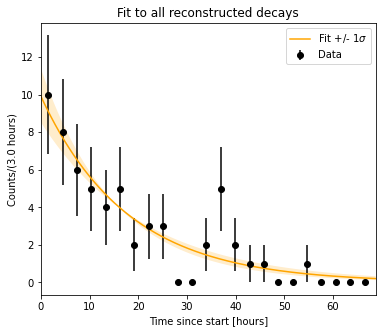

In [243]:
nbins = int(tot_livetime/3) + 2

decay_times_list = [decay_times,] # big_decay_times]

plt.figure(figsize=(6,5))
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,int(time_hours[-1])))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    #plt.subplot(1,2,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,time_hours[-1],1000)
    yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])

    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    #fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,time_hours[-1])
    plt.title(labs[j])
    plt.legend()

plt.savefig(plots_dir+"/decays_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

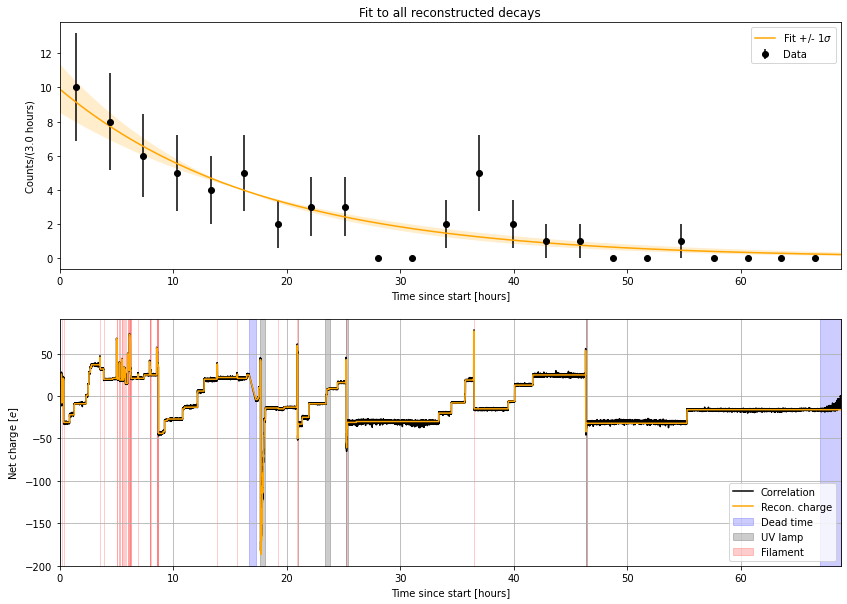

In [244]:
plt.figure(figsize=(14,10))
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,int(time_hours[-1])))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    plt.subplot(2,1,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,time_hours[-1],1000)
    yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])

    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    #fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,time_hours[-1])
    plt.title(labs[j])
    plt.legend()

plt.subplot(2,1,2)
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="lower right")
plt.xlim(0,time_hours[-1])

plt.savefig(plots_dir+"/decays_vs_time_with_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [245]:
def exp_fun(x, A, t12=10.6):
    lam = np.log(2)/t12
    return A*np.exp(-lam*x)

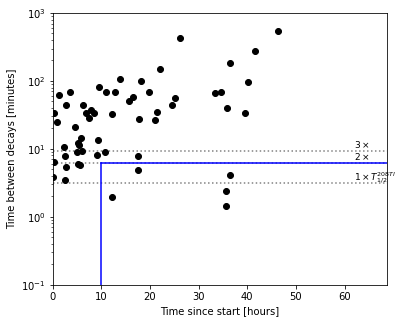

In [246]:
time_between = np.diff(good_change_list[:,0])

plt.figure(figsize=(6,5))
plt.semilogy(good_change_list[:,0][:-1], time_between*60, 'ko')
plt.xlim(0,time_hours[-1])
plt.ylim(0.1,1e3)
t12_tl208 = 3.1
for i in range(1,4):
    plt.plot([0,time_hours[-1]], [i*t12_tl208, i*t12_tl208], 'k:', alpha=0.5)
    if(i==1):
        plt.text(time_hours[-1]*0.9, i*t12_tl208*1.1, r"$%d \times T_{1/2}^{208Tl}$"%(i), fontsize=9, color='k')
    else:
        plt.text(time_hours[-1]*0.9, i*t12_tl208*1.1, r"$%d \times$"%(i), fontsize=9, color='k')

xcut, ycut = 10, 6.2

all_times = good_change_list[:,0][:-1]
cut_pos = (all_times > xcut) & (time_between*60 < ycut)
bi_decay_times = all_times[cut_pos]
cand_decay_times = all_times[np.roll(cut_pos,1)]


plt.plot( [xcut,xcut], [0.1, ycut], 'b')
plt.plot( [xcut,time_hours[-1]], [ycut, ycut], 'b')
plt.xlabel("Time since start [hours]")
plt.ylabel("Time between decays [minutes]")

plt.savefig(plots_dir+"/time_between_tl208_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

T12 = 28.3 +/- 6.4


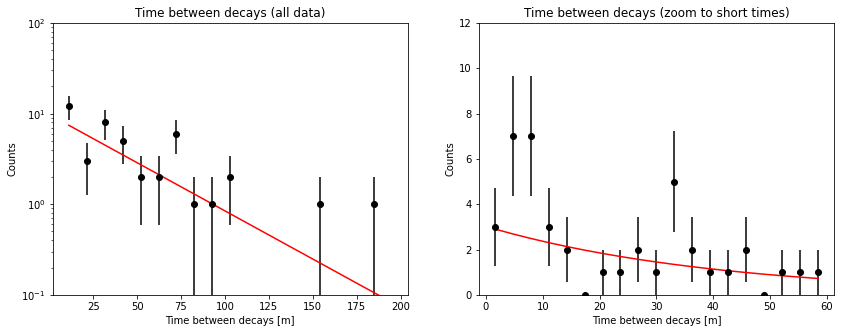

In [247]:
tbins = np.linspace(6,200,20)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2
bsize_orig = be[1]-be[0]

err = np.sqrt(hh)
err[err==0] = 1
bp, bcov = opt.curve_fit(exp_fun, bc, hh, p0=[20, 20], sigma=err)
print("T12 = %.1f +/- %.1f"%(bp[1], np.sqrt(bcov[1,1])))
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp), 'r')
plt.gca().set_yscale("log")
plt.ylim(0.1,100)
plt.xlabel("Time between decays [m]")
plt.ylabel("Counts")
plt.title("Time between decays (all data)")

plt.subplot(1,2,2)
tbins = np.linspace(0,60,20)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2

bsize_fac = (be[1]-be[0])/bsize_orig
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp)*bsize_fac, 'r')
#plt.gca().set_yscale("log")
plt.ylim(0,12)
plt.xlabel("Time between decays [m]")
plt.ylabel("Counts")
plt.title("Time between decays (zoom to short times)")

plt.savefig(plots_dir+"/time_between_fits_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


6586
9144
19049
19062
19451


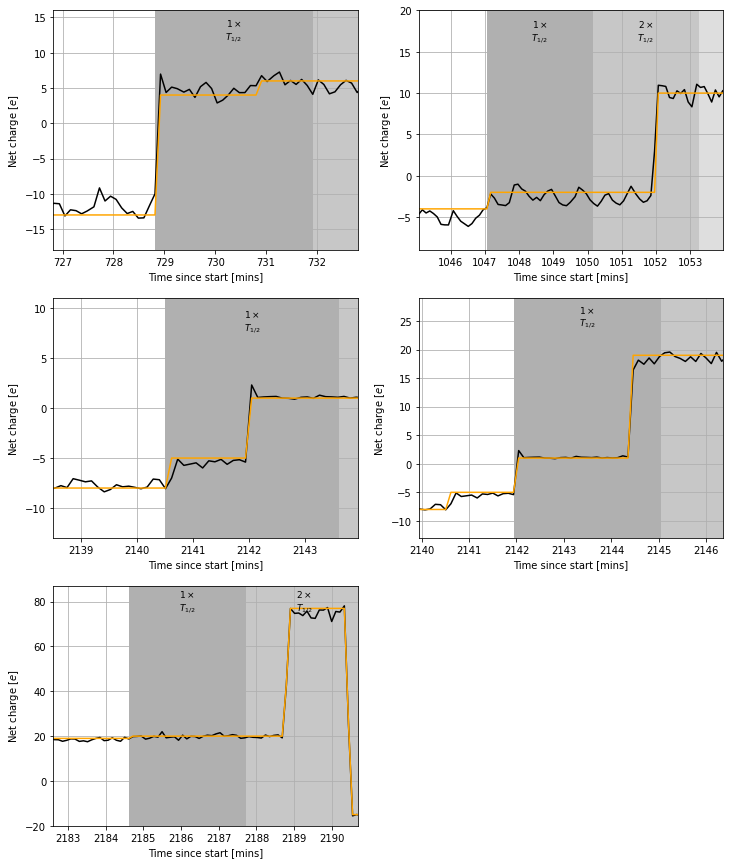

In [260]:
## now find the Tl-208 candidate decays and plot a zoom

nrows = int(len(cand_decay_times)/2) + 1

low_wind, high_wind = 2, 2
hrs_to_mins = 60

plt.figure(figsize=(12,nrows*5))
figidx = 1
for bi_hrs,cdt_hrs in zip(bi_decay_times,cand_decay_times):

    cdt = cdt_hrs*hrs_to_mins
    cdt_bi = bi_hrs*hrs_to_mins

    idx_of_bi = np.argmin(np.abs(time_hours[1:]*hrs_to_mins - cdt_bi))
    bi_time = time_hours[1:][idx_of_bi]*hrs_to_mins
    print(idx_of_bi)

    plt.subplot(nrows,2,figidx)
    plt.plot(time_hours[1:]*hrs_to_mins, corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
    plt.plot(time_hours[1:]*hrs_to_mins, running_charge, '-', color='orange', label="Recon. charge")
    plt.grid(True)
    gpts = (time_hours[1:]*hrs_to_mins > cdt_bi-low_wind) & (time_hours[1:]*hrs_to_mins < cdt+high_wind)
    y1, y2 = np.min(running_charge[gpts])-5, np.max(running_charge[gpts])+10
    plt.ylim(y1,y2)
    fill_dps(dead_period_edges)
    fill_dps(lamp_period_edges, 'black', lab="UV lamp")
    fill_dps(filament_period_edges, 'red', lab="Filament")
    plt.xlim(cdt_bi-low_wind, cdt+high_wind)


    for i in range(1,4):
        plt.fill_between([bi_time+(i-1)*t12_tl208, bi_time+i*t12_tl208], [y1, y1], [y2, y2], color='k', alpha=0.4-(i*0.09),edgecolor=None)
        xp = np.mean([bi_time+(i-1)*t12_tl208, bi_time+i*t12_tl208])
        if(xp > cdt+high_wind): break
        plt.text(xp, y2-1, r"$%d \times$"%i +"\n$T_{1/2}$", fontsize=9, color='k', verticalalignment='top', horizontalalignment='center')
    plt.xlabel("Time since start [mins]")
    plt.ylabel("Net charge [$e$]")
    figidx+=1
    #plt.legend(loc="upper left")
    plt.savefig(plots_dir+"/candidate_bi_tl_%s.png"%file_label, dpi=300, bbox_inches="tight")

16.0
16.0
16.0
16.0


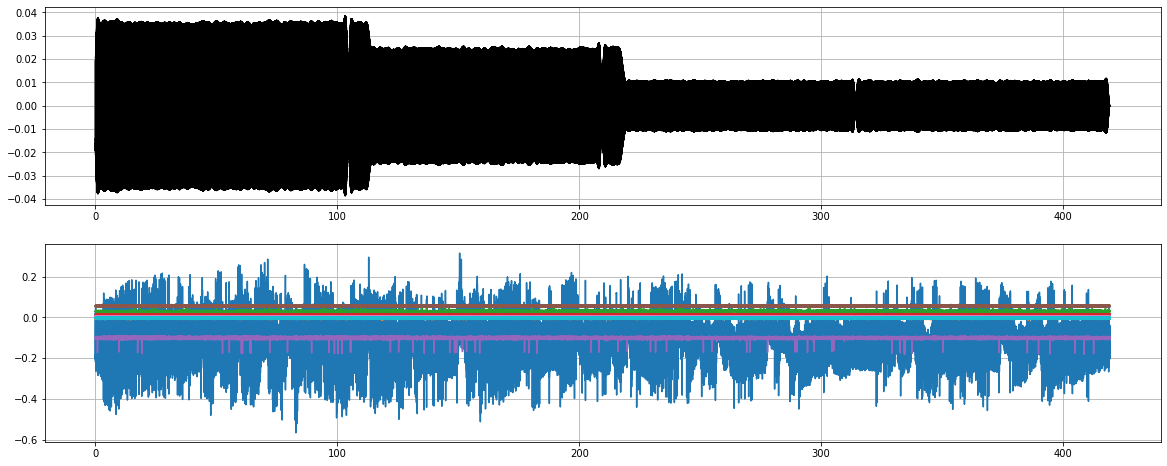

In [249]:
## code to plot individual files charge change
#cdat, attr, fhandle = bu.get_data(data_list[int(1210/16)])
idx=2720
nfiles = 4
plt.figure(figsize=(20,8))
for nf in range(nfiles):

    cdat, attr, fhandle = bu.get_data(data_list[int(idx/16)+nf])  ## correlated decays 20 s apart?
    #fn = np.array([104, 117])/5000
    fn = np.array([110.5, 111.5])/5000
    b,a = sig.butter(3, fn, btype='bandpass')
    fdat = sig.filtfilt(b,a,cdat[:,0])
    print(len(fdat)/2**16)

    tvec = np.arange(0, len(fdat))/1e4 + nf*(len(fdat)-1)/1e4


    plt.subplot(2,1,1)
    plt.plot(tvec,fdat, 'k')
    plt.grid(True)

    plt.subplot(2,1,2)
    for i in range(10):
        fdat = cdat[:,2+i]
        plt.plot(tvec,fdat)
    plt.grid(True)

    #plt.xlim(50,58)
    #plt.ylim(0.06, 0.10)

#plt.figure()
#f,p = sig.welch(cdat[:,0], fs=1e4,nperseg=2**16)
#plt.semilogy(f,p)
#plt.xlim(100,120)

Now let's analyze whether there are any kicks correlated with the charge changes:

In [250]:
## create list of calibration files 
calib_file_dict = {}
for curr_path in calib_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "**MeV/*.h5"), recursive=True))

    for file in curr_file_list:
        impulse_amp = bu.parse_impulse_amplitude(file)
        if impulse_amp in calib_file_dict.keys():
            calib_file_dict[impulse_amp].append(file)
        else:
            calib_file_dict[impulse_amp] = [file,]

noise_file_list = []
for curr_path in calib_noise_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5"), recursive=True))
    if(len(noise_file_list)>0):
        noise_file_list.append(curr_file_list)
    else:
        noise_file_list = curr_file_list

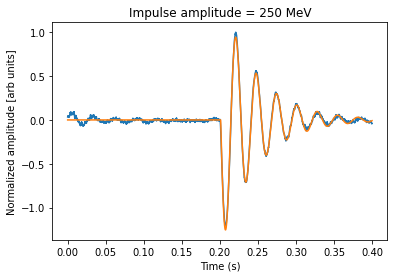

In [251]:
# calculate the pulse tempates by averaging all calibration files
importlib.reload(bu)
template_dict, template_dict_fit, fit_vals = bu.get_average_template(calib_file_dict, make_plots=True, 
                                                                     fit_pars=[-1,2*np.pi*30,10,0.20], drive_idx=10)

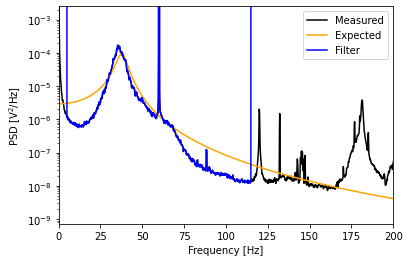

In [252]:
## noise from the same time as the calibration
importlib.reload(bu)
res_pars = [np.median(fit_vals[:,1]), np.median(fit_vals[:,3])]
noise_dict = bu.get_noise_template(noise_file_list, res_pars=res_pars, nfft=2**16)

In [253]:
importlib.reload(bu)
opt_filt_amps, phi_t = bu.optimal_filt(calib_file_dict, template_dict_fit, noise_dict, time_offset=-12, drive_idx=10, cal_fac=288.5, make_plots=False)
time_corr_amps = bu.correlation_filt(calib_file_dict, template_dict_fit, bandpass=[5,70], notch_list = [], drive_idx=10, make_plots=False)
bandpass_amps = bu.bandpass_filt(calib_file_dict, template_dict_fit, time_offset=0, bandpass=[5,70], drive_idx=10, cal_fac = 7550, make_plots=False)

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:836: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(bcorr, acorr, corr_data**2))


In [254]:
## calculate pedestal with search bias by time offset away from pulse
opt_filt_pedestal, _ = bu.optimal_filt(calib_file_dict, template_dict_fit, noise_dict, time_offset=2000, drive_idx=10, cal_fac=288.5, make_plots=False)
bandpass_pedestal = bu.bandpass_filt(calib_file_dict, template_dict_fit, time_offset=-500, bandpass=[5,70], drive_idx=10, cal_fac = 7550, make_plots=False)

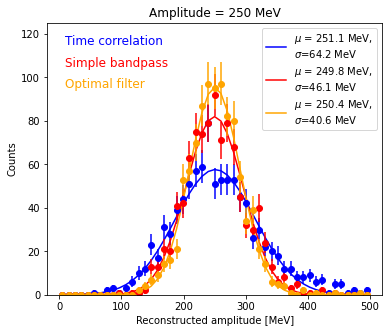

In [255]:
amp_bins = np.arange(0,100,2)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals = []

amp_dicts = [time_corr_amps, bandpass_amps, opt_filt_amps]
amp_methods = ["Time correlation", "Simple bandpass", "Optimal filter"]
amp_cal_facs = [64.5, 7550, 288.5] ## set by hand to match the calibration data
amp_colors = ['b', 'r', 'orange']

ymax = 125

plt.figure(figsize=(6,5))    
for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(filt_amps.keys()):
        if( not isinstance(amp, numbers.Number)): continue
        amp_bins = np.linspace(0,2*amp,50)
        hh,be = np.histogram(filt_amps[amp]*amp_cal_facs[i], bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        #plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")

        plt.text(10, ymax-10*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        #plt.suptitle(amp_methods[i])
        plt.legend()

    plt.ylim(0,ymax)
    plt.savefig(plots_dir+"/calib_reconstructed_amplitudes_%s.png"%file_label, dpi=300)

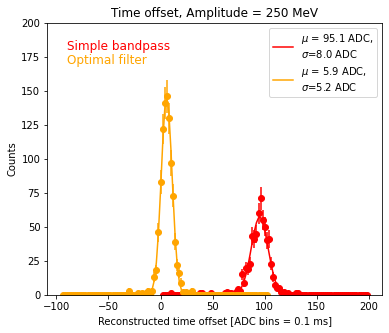

In [256]:
fit_vals_offset = []

ymax = 200

plt.figure(figsize=(6,5))    
for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(filt_amps.keys()):
        if( isinstance(amp, numbers.Number)): continue
        amp_val = float(amp.split("_")[0])

        cent_time = np.median(filt_amps[amp])
        offset_bins = np.arange(cent_time-100,cent_time + 100,2) 

        hh,be = np.histogram(filt_amps[amp], bins=offset_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, np.median(filt_amps[amp]), np.std(filt_amps[amp])])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals_offset.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        #plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f ADC,\n$\sigma$=%.1f ADC"%(gp[1], gp[2]))
        plt.title("Time offset, Amplitude = %d MeV"%amp_val)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed time offset [ADC bins = 0.1 ms]")
        plt.ylim(0,ymax)

        plt.text(-90, ymax-10*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        plt.legend()

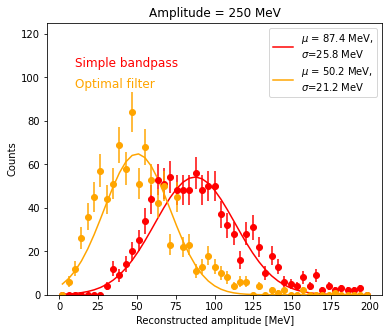

In [257]:
### now pedestal for band pass, opt filt
amp_dicts = [{}, bandpass_pedestal, opt_filt_pedestal]
amp_colors = [_, 'r', 'orange']

ymax = 125

plt.figure(figsize=(6,5))    
for i,filt_amps in enumerate(amp_dicts):
    
    for j,amp in enumerate(filt_amps.keys()):

        if( not isinstance(amp, numbers.Number)): continue
        amp_bins = np.linspace(0,200,50)
        hh,be = np.histogram(filt_amps[amp]*amp_cal_facs[i], bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        #plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")

        plt.text(10, ymax-10*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        #plt.suptitle(amp_methods[i])
        plt.legend()

    plt.ylim(0,ymax)
    plt.savefig(plots_dir+"/calib_pedestal_%s.png"%file_label, dpi=300)

In [261]:
remake_files = False

if(remake_files):
    nsegs = 2**6 ## number of segments to chop up for Welch's method
    cdat, attr, fhandle = bu.get_data(data_list[0])
    nps = int(len(cdat[:,0])/nsegs)

    files_to_use = data_list
    noise_arr = np.zeros((len(files_to_use), int(nps/2)+1))
    time_arr = np.zeros(len(files_to_use))
    for i,f in enumerate(files_to_use):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        xdata = cdat[:,0]
        cf, cpsd = sig.welch(xdata, fs=attr['Fsamp'], nperseg=nps)
        
        noise_arr[i,:] = cpsd
        time_arr[i] = attr["Time"]

    freqs = cf
    time_arr -= time_arr[0] # time since start
    time_arr /= 3600 ## convert to hours
    np.savez(os.path.join(data_dir, "noise_data_vs_time.npz"), noise_arr=noise_arr, time_arr=time_arr, freqs=freqs)
else:
    npzfile = np.load(os.path.join(data_dir, "noise_data_vs_time.npz"))
    noise_arr = npzfile['noise_arr']
    time_arr = npzfile['time_arr']
    freqs = npzfile['freqs']

In [262]:
## time of calibration
cdat, attr, fhandle = bu.get_data(calib_file_dict[250.0][0])
tcal = attr["Time"]

cdat, attr, fhandle = bu.get_data(noise_file_list[-1])
tcal_end = attr["Time"]

cdat, attr, fhandle = bu.get_data(data_list[0])
tstart = attr["Time"]

cal_start = (tcal-tstart)/3600
cal_end = (tcal_end-tstart)/3600
print(cal_start, cal_end)

-283.12064117126994 -245.82660107400682


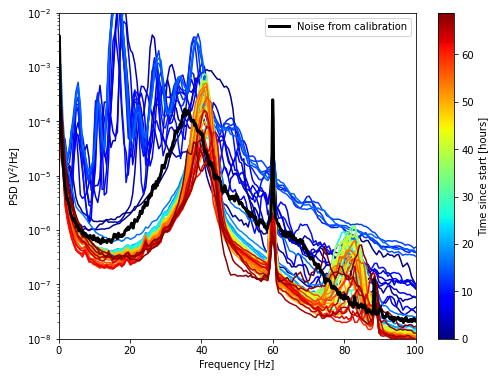

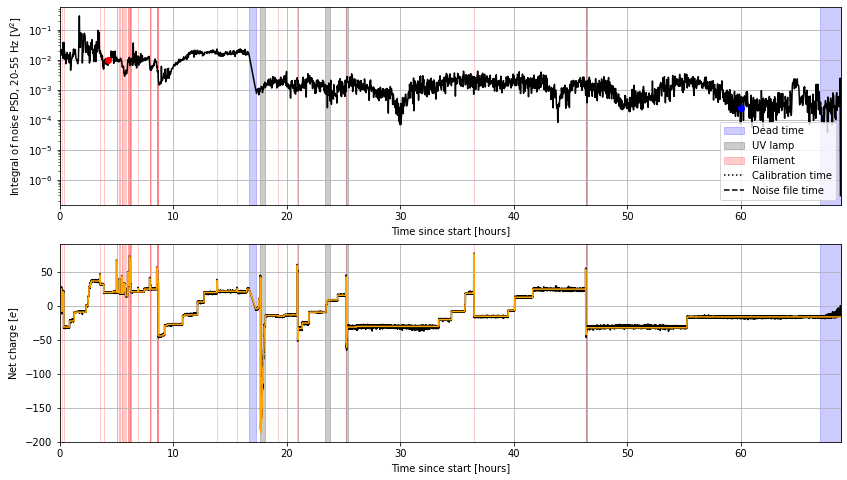

In [268]:
## make a plot of the noise vs time
plt.figure(figsize=(8,6))

nstep = 40
n = int(np.sum(time_arr>-1)/nstep)+1
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, n)]

integ_pts_lo = (freqs>10) & (freqs<20)
integ_pts_hi = (freqs>20) & (freqs<55)

cidx = 0
noise_vs_time = []
for i in range(np.shape(noise_arr)[0]):
    #if(time_arr[i] > 55): break
    if(i%nstep == 0):
        plt.semilogy(freqs, np.median(noise_arr[i:(i+nstep),:], axis=0), color=colors[cidx])
        cidx+=1


    integ_lo = np.trapz(noise_arr[i,integ_pts_lo], x=freqs[integ_pts_lo]) 
    integ_hi = np.trapz(noise_arr[i,integ_pts_hi], x=freqs[integ_pts_hi]) 

    noise_vs_time.append([time_arr[i], integ_lo, integ_hi])
        
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=time_arr[0], vmax=time_arr[-1]))
sm.set_array([])
ax = plt.gca()
plt.colorbar(sm, ax=ax, label="Time since start [hours]")

plt.semilogy(noise_dict['freq'], noise_dict['Jorig'], 'k-', label="Noise from calibration", lw=3)

plt.legend()
plt.xlim(0,100)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V$^2$/Hz]")
plt.ylim(1e-8, 1e-2)

plt.savefig(plots_dir+"/noise_spec_vs_time_%s.png"%file_label, dpi=300)

noise_vs_time = np.array(noise_vs_time)

## compare file at 35 hours to one at 21 hours
bad_idx = np.argmin(np.abs(noise_vs_time[:,0]-4.25))
good_idx = np.argmin(np.abs(noise_vs_time[:,0]-60))

plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
#plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,1], 'b')
plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,2], 'k')
plt.semilogy(noise_vs_time[bad_idx,0], noise_vs_time[bad_idx,2], 'ro')
plt.semilogy(noise_vs_time[good_idx,0], noise_vs_time[good_idx,2], 'bo')
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Integral of noise PSD, 20-55 Hz [V$^2$]")
#plt.legend(loc="upper right")
yy = plt.ylim()
plt.plot([cal_start, cal_start], yy, 'k:', label="Calibration time")
plt.plot([cal_end, cal_end], yy, 'k--', label="Noise file time")
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
#plt.legend(loc="upper right")

plt.savefig(plots_dir+"/noise_vs_time_%s.png"%file_label, dpi=300)

plt.show()

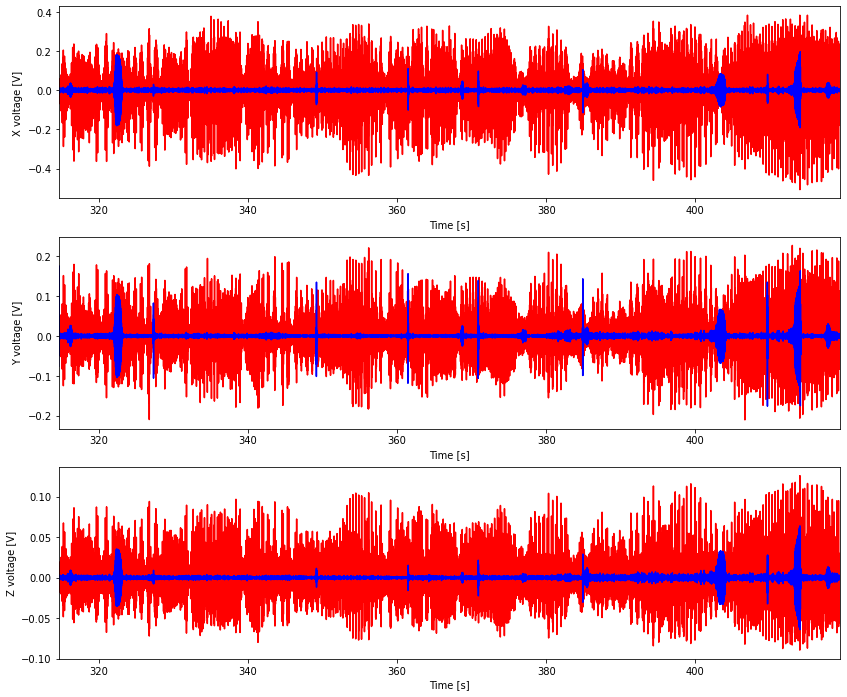

In [269]:
## compare an example "good" and "bad" file
bad_dat, attr, fhandle = bu.get_data(data_list[bad_idx])
good_dat, attr, fhandle = bu.get_data(data_list[good_idx])

plt.figure(figsize=(14,12))

fc = np.array([20, 55])/(attr['Fsamp']/2)
b,a = sig.butter(3, fc, btype='bandpass')

coord = ['X', 'Y', 'Z']
for i in range(3):
    plt.subplot(3,1,i+1)

    bd = sig.filtfilt(b,a,bad_dat[:,i])
    gd = sig.filtfilt(b,a,good_dat[:,i])

    plt.plot(tvec, bd, 'r')
    plt.plot(tvec, gd, 'b')
    plt.xlim(tvec[0], tvec[-1])
    plt.xlabel("Time [s]")
    plt.ylabel(coord[i] + " voltage [V]")

plt.savefig(plots_dir+"/noise_bursts_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

In [270]:
remake_files = False


if(remake_files):

    fc = np.array([20, 55])/(attr['Fsamp']/2)
    b,a = sig.butter(3, fc, btype='bandpass')

    files_to_use = data_list
    noise_rms = np.zeros(len(files_to_use))
    time_arr = np.zeros(len(files_to_use))
    for i,f in enumerate(files_to_use):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        xdata = cdat[:,0]
        noise_rms[i] = np.median( np.sqrt( sig.filtfilt(b,a,xdata)**2 ) )
        time_arr[i] = attr["Time"]

    time_arr -= time_arr[0] # time since start
    time_arr /= 3600 ## convert to hours
    np.savez(os.path.join(data_dir, "noise_rms_vs_time.npz"), noise_rms=noise_rms, time_arr=time_arr)
else:
    npzfile = np.load(os.path.join(data_dir, "noise_rms_vs_time.npz"))
    noise_rms = npzfile['noise_rms']
    time_arr = npzfile['time_arr']

working on file 0: /Volumes/DATA/20231009/1/LPmbar_xyzcool_0.h5
working on file 10: /Volumes/DATA/20231009/1/LPmbar_xyzcool_10.h5
working on file 20: /Volumes/DATA/20231009/1/LPmbar_xyzcool_20.h5
working on file 30: /Volumes/DATA/20231009/1/LPmbar_xyzcool_30.h5
working on file 40: /Volumes/DATA/20231009/1/LPmbar_xyzcool_40.h5
working on file 50: /Volumes/DATA/20231009/1/LPmbar_xyzcool_50.h5
working on file 60: /Volumes/DATA/20231009/1/LPmbar_xyzcool_60.h5
working on file 70: /Volumes/DATA/20231009/1/LPmbar_xyzcool_70.h5
working on file 80: /Volumes/DATA/20231009/1/LPmbar_xyzcool_80.h5
working on file 90: /Volumes/DATA/20231009/1/LPmbar_xyzcool_90.h5
working on file 100: /Volumes/DATA/20231009/1/LPmbar_xyzcool_100.h5
working on file 110: /Volumes/DATA/20231009/1/LPmbar_xyzcool_110.h5
working on file 120: /Volumes/DATA/20231009/1/LPmbar_xyzcool_120.h5
working on file 130: /Volumes/DATA/20231009/1/LPmbar_xyzcool_130.h5
working on file 140: /Volumes/DATA/20231009/1/LPmbar_xyzcool_140.h5
wo

TypeError: fill_dps() missing 1 required positional argument: 'dead_period_edges'

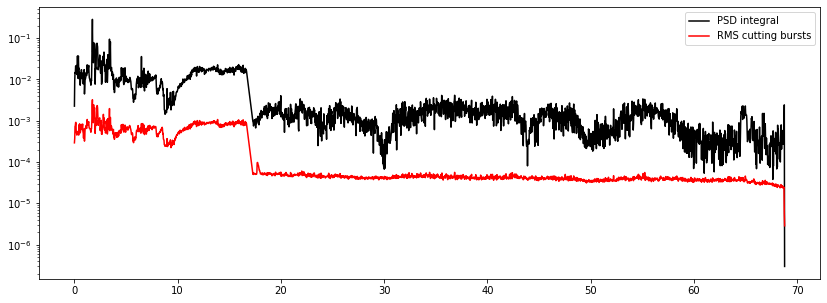

In [271]:
plt.figure(figsize=(14,5))

plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,2], 'k', label="PSD integral")
plt.semilogy(time_arr, noise_rms/1e2, 'r', label="RMS cutting bursts")
plt.legend()
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(0,time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Noise PSD/RMS [V$^2$]")

plt.savefig(plots_dir+"/noise_rms_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.ylim(6e-5, 5e-3)
plt.grid(True, which='both')

plt.savefig(plots_dir+"/noise_rms_zoom_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
idx_of_charge_changes = np.where(changes)[0]
good_changes = np.diff(idx_of_charge_changes) > 0
good_changes = np.hstack((good_changes,[True])) ## add the last one
idx_of_charge_changes = idx_of_charge_changes[good_changes]

file_idx_of_charge_changes = idx_of_charge_changes/num_pts_per_file
#for i in file_idx_of_charge_changes:
#    print("%d, 0"%i)

In [ ]:
## now assemble a list of the candidate decays and use the recon methods above to look for pulses
remake_files = True


importlib.reload(bu)

cal_fac_fine, cal_fac_coarse = 6126.7*4, 47.57*4 ## factor of 4 for (30 mV/15 mV)^2

idx_to_use = [0,1,2]
step_times = np.loadtxt(os.path.join(data_dir, "step_times_%s.txt"%file_label), delimiter=',')
xwind = 5
cwind = 0.5

save_png = [2, 32, 41]

if(remake_files):
    pdf = PdfPages(os.path.join(plots_dir, "candidate_decays_%s.pdf"%file_label))

    ## roll to the average difference in max times
    filt_bins_offset = int(fit_vals_offset[0][1]-fit_vals_offset[1][1])

    pulse_data = []
    for j,idx in enumerate(np.unique(np.floor(file_idx_of_charge_changes))):
        print("working on file: ", int(idx))
        #if(j>0): break
        step_idx = np.floor(step_times[:,0]).astype(int).tolist().index(int(idx))
        step_time = step_times[step_idx,1]
        if(step_time == 0): step_time = 50
        if(step_time < 0): continue

        cfile = data_list[int(idx)]
        cdat, attr, _ = bu.get_data(cfile)
        yup = 500 #if idx > 500 else 800
        fig, step_params = bu.plot_impulse_with_recon(cdat, attr, phi_t, cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                amp_cal_facs=[amp_cal_facs[1], amp_cal_facs[2]], ylim_init=yup,
                                xrange=[step_time-xwind,step_time+xwind], charge_range=[step_time-cwind,step_time+cwind],
                                filt_time_offset = filt_bins_offset, drive_idx=8)
        
        pulse_data.append(step_params)

        plt.figure(fig.number)
        file_parts = '/'.join(cfile.split("/")[-2:])
        ctime = (attr['Time']-corr_vec[0,-1])/3600
        plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))

        if(idx in save_png):
            plt.savefig(plots_dir+"/candidate_decay_%s_%d.png"%(file_label, idx), dpi=75, bbox_inches="tight")

        try:
            pdf.savefig(dpi=75)
        except TimeoutError:
            print("Timeout error, trying again")
            pdf.savefig(dpi=75)
        plt.close(fig)

    pdf.close()
    pulse_data = np.array(pulse_data)
    np.save(os.path.join(data_dir, "pulse_recon_data_%s.npy"%file_label), pulse_data)
else:
    pulse_data = np.load(os.path.join(data_dir, "pulse_recon_data_%s.npy"%file_label))

working on file:  2
working on file:  19
working on file:  29
working on file:  32
working on file:  41
working on file:  49
working on file:  59
working on file:  68
working on file:  80
working on file:  118
working on file:  150
working on file:  189
working on file:  196
working on file:  203
working on file:  208
working on file:  225
working on file:  230
working on file:  248
working on file:  262
working on file:  265
working on file:  281
working on file:  355


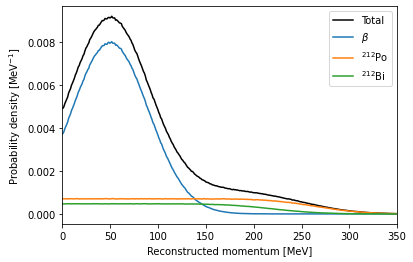

In [ ]:
## what is the expected distribution of amplitudes projected onto x:
npts = int(1e7)
phi = 2*np.pi*np.random.rand(npts)
theta = np.arccos(2*np.random.rand(npts)-1)

## beta, Po212, Bi212
decay_momenta = [0, 265, 220] ## MeV
branching_fractions = [0.58, 0.27, 0.15] ## fraction of decays
labels = [r'$\beta$', '$^{212}$Po', '$^{212}$Bi']
noise = 40 ## MeV

bins = np.linspace(0, 350, 350)
htot = np.zeros(len(bins)-1)
hlist = []
for j,dm in enumerate(decay_momenta):
    curr_vals = dm*np.sin(theta)*np.cos(phi) + np.random.randn(npts)*noise 
    if(dm == 0):
        curr_vals += 50 ## pedestal dominates for beta decays
    hh, be = np.histogram(curr_vals, bins=bins)
    hlist.append(branching_fractions[j]*hh)
    htot += branching_fractions[j]*hh

norm = np.sum(htot)
htot /= norm

bc = bins[:-1] + 0.5*np.diff(bins)

plt.figure()
plt.plot(bc, htot, 'k', label='Total')

for j,hh in enumerate(hlist):
    plt.plot(bc, hh/norm, label=labels[j])

plt.xlabel("Reconstructed momentum [MeV]")
plt.ylabel("Probability density [MeV$^{-1}$]")
plt.xlim(0,350)

exp_bins = bc
exp_pdf = htot

plt.legend()
plt.savefig(plots_dir+"/expected_spectrum_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


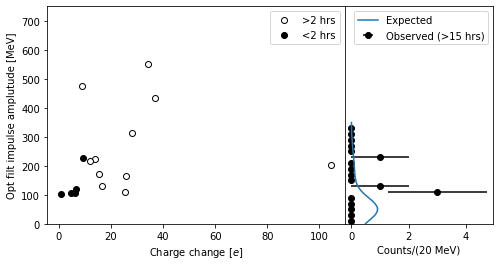

In [ ]:
## plot the reconstructed impulse amplitude versus the charge change
ymax = 750
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(8, 4), width_ratios=[2,1])

cut_idx = 5

plt.sca(scatter_ax)
plt.plot(pulse_data[cut_idx:,2], pulse_data[cut_idx:,0], 'ko', mfc='white', label=">2 hrs")
plt.plot(pulse_data[:cut_idx,2], pulse_data[:cut_idx,0], 'ko', label="<2 hrs")
xx = np.linspace(0,time_hours[-1])
#plt.plot(xx, 626/60*xx + 50, 'b:')
plt.ylim(0,ymax)
plt.xlabel("Charge change [$e$]")
plt.ylabel("Opt filt impulse amplutude [MeV]")
plt.legend()

hh, be = np.histogram(pulse_data[:cut_idx,0], bins=17, range=(0,340))
bc = be[:-1] + np.diff(be)/2
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko', label='Observed (>15 hrs)', zorder=0)
hist_ax.plot(exp_pdf*20*len(pulse_data[:cut_idx,0]), exp_bins, label='Expected')
plt.yticks([])
plt.ylim(0,ymax)
plt.xlabel("Counts/(20 MeV)")
plt.legend()

plt.subplots_adjust(wspace=0)


plt.savefig(plots_dir+"/amp_vs_charge_change_%s.png"%file_label, dpi=300, bbox_inches="tight")

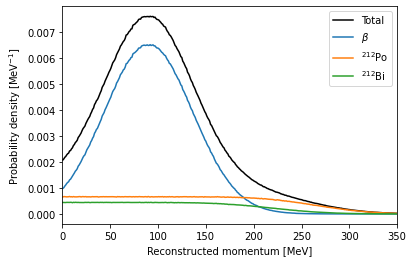

In [ ]:
### now the same for the bandpass filter #########################



## what is the expected distribution of amplitudes projected onto x:
npts = int(1e7)
phi = 2*np.pi*np.random.rand(npts)
theta = np.arccos(2*np.random.rand(npts)-1)

## beta, Po212, Bi212
decay_momenta = [0, 265, 220] ## MeV
branching_fractions = [0.58, 0.27, 0.15] ## fraction of decays
labels = [r'$\beta$', '$^{212}$Po', '$^{212}$Bi']
noise = 46 ## MeV

bins = np.linspace(0, 350, 350)
htot = np.zeros(len(bins)-1)
hlist = []
for j,dm in enumerate(decay_momenta):
    curr_vals = dm*np.sin(theta)*np.cos(phi) + np.random.randn(npts)*noise 
    if(dm == 0):
        curr_vals += 90 ## pedestal dominates for beta decays, long window (0.1s)
    hh, be = np.histogram(curr_vals, bins=bins)
    hlist.append(branching_fractions[j]*hh)
    htot += branching_fractions[j]*hh

norm = np.sum(htot)
htot /= norm

bc = bins[:-1] + 0.5*np.diff(bins)

plt.figure()
plt.plot(bc, htot, 'k', label='Total')

for j,hh in enumerate(hlist):
    plt.plot(bc, hh/norm, label=labels[j])

plt.xlabel("Reconstructed momentum [MeV]")
plt.ylabel("Probability density [MeV$^{-1}$]")
plt.xlim(0,350)

exp_bins = bc
exp_pdf = htot

plt.legend()
plt.savefig(plots_dir+"/expected_spectrum_bp_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


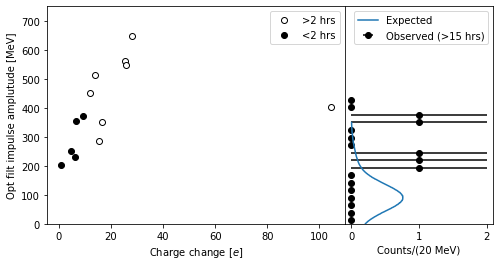

In [ ]:
## plot the reconstructed impulse amplitude versus the charge change (bandpass)
ymax = 750
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(8, 4), width_ratios=[2,1])

cut_idx = 5

plt.sca(scatter_ax)
plt.plot(pulse_data[cut_idx:,2], pulse_data[cut_idx:,1], 'ko', mfc='white', label=">2 hrs")
plt.plot(pulse_data[:cut_idx,2], pulse_data[:cut_idx,1], 'ko', label="<2 hrs")
xx = np.linspace(0,time_hours[-1])
#plt.plot(xx, 626/60*xx + 50, 'b:')
plt.ylim(0,ymax)
plt.xlabel("Charge change [$e$]")
plt.ylabel("Opt filt impulse amplutude [MeV]")
plt.legend()

hh, be = np.histogram(pulse_data[:cut_idx,1], bins=17, range=(0,440))
bc = be[:-1] + np.diff(be)/2
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko', label='Observed (>15 hrs)', zorder=0)
hist_ax.plot(exp_pdf*20*len(pulse_data[:cut_idx,1]), exp_bins, label='Expected')
plt.yticks([])
plt.ylim(0,ymax)
plt.xlabel("Counts/(20 MeV)")
plt.legend()

plt.subplots_adjust(wspace=0)



plt.savefig(plots_dir+"/amp_vs_charge_change_bp_%s.png"%file_label, dpi=300, bbox_inches="tight")

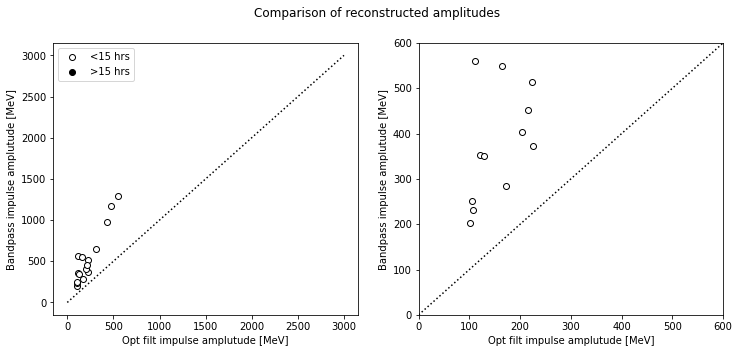

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(pulse_data[:36,0], pulse_data[:36,1], 'ko', mfc='white', label="<15 hrs")
plt.plot(pulse_data[36:,0], pulse_data[36:,1], 'ko', label=">15 hrs")
plt.plot([0,3000], [0,3000], 'k:')
plt.legend()

plt.xlabel("Opt filt impulse amplutude [MeV]")
plt.ylabel("Bandpass impulse amplutude [MeV]")

plt.subplot(1,2,2)
plt.plot(pulse_data[:36,0], pulse_data[:36,1], 'ko', mfc='white', label="<15 hrs")
plt.plot(pulse_data[36:,0], pulse_data[36:,1], 'ko', label=">15 hrs")
plt.plot([0,3000], [0,3000], 'k:')
plt.xlim(0,600)
plt.ylim(0,600)
plt.xlabel("Opt filt impulse amplutude [MeV]")
plt.ylabel("Bandpass impulse amplutude [MeV]")

plt.suptitle("Comparison of reconstructed amplitudes")

plt.savefig(plots_dir+"/opt_bp_comp_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [ ]:
## last, let's look at the photodiode data
cdat, attr, _ = bu.get_data('/Volumes/DATA/20230925/meas/1_PD/Alpha_0.h5')

Warning, got no keys for:  /Volumes/DATA/20230925/meas/1_PD/Alpha_0.h5


In [ ]:
print(data_list[0])

/Volumes/DATA/20231004/1/meas/1/LPmbar_xyzcool_0.h5


In [ ]:
import h5py
f = h5py.File('/Volumes/DATA/20230925/meas/1_PD/Alpha_2.h5','r')

In [ ]:
np.array(f['realtime'])
np.array(f['time'])

array([0.00000e+00, 3.20000e-08, 6.40000e-08, ..., 5.24192e-04,
       5.24224e-04, 5.24256e-04])

In [ ]:
f.keys()

<KeysViewHDF5 ['NFFT', 'communicate_time', 'realtime', 'time', 'voltage']>

In [ ]:
np.array(f['realtime'])

array(b'20:29:03.762598', dtype=object)

In [ ]:
np.array(f['communicate_time'])

array(2710.781093)

In [ ]:
remake_files = True
importlib.reload(bu)

if(remake_files):
    pdf = PdfPages(os.path.join(plots_dir, "candidate_alpha_det_%s.pdf"%file_label))

    for j,idx in enumerate(np.unique(np.floor(file_idx_of_charge_changes))):
        print("working on file: ", int(idx))
        #if(j>2): break
        step_idx = np.floor(step_times[:,0]).astype(int).tolist().index(int(idx))
        step_time = step_times[step_idx,1]
        if(step_time <= 0): step_time = 50

        cfile = data_list[int(idx)]
        cdat, attr, _ = bu.get_data(cfile)

        fig = bu.plot_step_with_alphas(cdat, attr, xrange=[step_time-xwind,step_time+xwind], cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                    charge_range=[step_time-cwind,step_time+cwind])

        file_parts = '/'.join(cfile.split("/")[-2:])
        ctime = (attr['Time']-corr_vec[0,-1])/3600
        plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
        try:
            pdf.savefig(dpi=75)
        except TimeoutError:
            print("Timeout error, trying again")
            pdf.savefig(dpi=75)
        plt.close(fig)

    pdf.close()


working on file:  2
working on file:  19
working on file:  29
working on file:  32
working on file:  41
working on file:  49
working on file:  59
working on file:  68
working on file:  80
working on file:  118
working on file:  150
working on file:  189
working on file:  196
working on file:  203
working on file:  208
working on file:  225
working on file:  230
working on file:  248
working on file:  262
working on file:  265
working on file:  281
working on file:  355
